In [129]:
import pandas as pd
path = 'algoTrade-master/data/ch08/s&p500.csv'
snp500_df = pd.read_csv(path,usecols=['Adj Close'])

In [103]:
snp500_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5034 non-null   float64
dtypes: float64(1)
memory usage: 39.5 KB


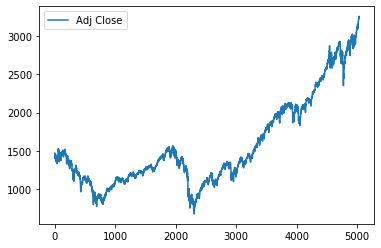

In [130]:
import matplotlib.pyplot as plt
import numpy as np
snp500_df.plot()

노이즈를 제거하고자 일차적으로 가격데이터를 수익률 데이터로 변환 

**주가 데이터를 로그 수익률 데이터로 변환하면 정규분포에 가까워짐

In [131]:
snp500_df['pct_change'] = snp500_df['Adj Close'].pct_change()
snp500_df['log_ret'] = np.log(snp500_df['Adj Close']) - np.log(snp500_df['Adj Close'].shift(1))

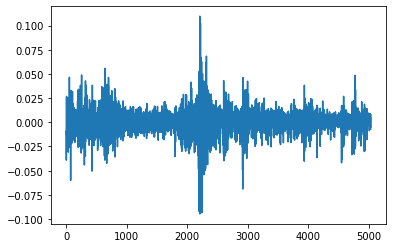

In [132]:
snp500_df['log_ret'].plot()

In [133]:
from sklearn.preprocessing import MinMaxScaler
window_length = 10
scaler = MinMaxScaler()
X_train = np.array([scaler.fit_transform(snp500_df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in range(window_length+1,len(snp500_df['log_ret']))])

In [134]:
X_train.shape

(5023, 10, 1)

In [135]:
test_samples = 200
X_train = X_train[:-test_samples] #뒤에서부터 나누기
X_test = X_train[-test_samples:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('테스트 데이터 비율 : {:.2f}%'.format(test_samples/len(X_train)*100))

테스트 데이터 비율 : 4.15%


# MLP(Multi-Layer Perceptron)

In [47]:
from keras.layers import Input,Dense
from keras.models import Model

# 10개 입력층 -> 3개 은닉층 -> 10개 출력층
window_length = 10
encoding_dim = 3
epochs = 100

X_train_simple = X_train.reshape((len(X_train),np.prod(X_train.shape[1:]))) #신경망 입력을 위해 3차원->2차원 데이터로 변환 (len,10)
X_test_simple = X_test.reshape((len(X_test),np.prod(X_test.shape[1:])))

input_window = Input(shape=(window_length,)) #입력 데이터 구조 정의
encoded = Dense(encoding_dim,activation='relu')(input_window) # input data 를 encode로 압축 : 10차원 -> 3차원
decoded = Dense(window_length,activation='sigmoid')(encoded) # 압축된 데이터를 input data로 최대한 표현 : 3차원 -> 10차원

autoencoder = Model(input_window, decoded) # 인풋데이터를 인코더 디코더를 통해 인풋값을 예측하는 모델
encoder = Model(input_window,encoded) #인풋데이터를 인코더 디코더로 압축하는 모델

autoencoder.summary()
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
history = autoencoder.fit(X_train_simple, X_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(X_test_simple, X_test_simple))


decoded_stocks = autoencoder.predict(X_test_simple)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 34ms/step - loss: 0.6983 - val_loss: 0.6984
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6976 - val_loss: 0.6977
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6969 - val_loss: 0.6971
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 0.6963 - val_loss: 0.6966
E

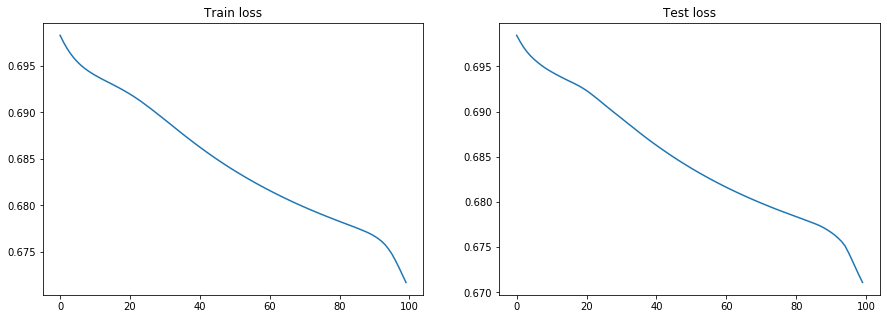

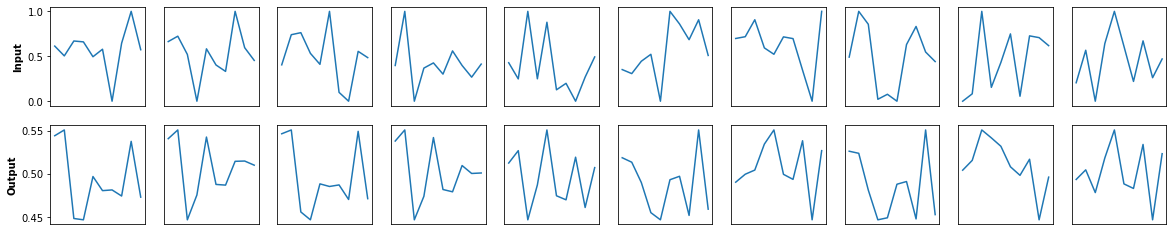

In [48]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 20))): # 0부터 test_samples(=200) 까지 20씩 증가 i=0,1,2 ...,idx=0,20,40,...
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")


plot_history(history)
plot_examples(X_test_sample,decoded_stocks)

# Deep-AutoEncoder

In [50]:
from keras.layers import BatchNormalization

# 10 -> 6 -> 6(정규화) -> 3 -> 6 -> 6(정규화) -> 10

X_train_deep =  X_train.reshape((len(X_train),np.prod(X_train.shape[1:])))
X_test_deep =  X_test.reshape((len(X_test),np.prod(X_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6,activation='relu')(input_window) #완전 연결층을 정의하면서 출력유닛을 6차원으로 축소하여 전달
x = BatchNormalization()(x) # 학습이 잘 이뤄지도록 정규화
encoded = Dense(encoding_dim,activation='relu')(x) # 완전 연결층을 정의하면서 encoding(=3)차원으로 축소전달

x = Dense(6,activation='relu')(encoded) # 3차원 -> 6차원으로 확장
x = BatchNormalization()(x) # 정규화
decoded = Dense(window_length,activation='sigmoid')(x) # 출력층으로 10차원으로 변환

autoencoder = Model(input_window,decoded)
encoder = Model(input_window,encoded)

autoencoder.summary()
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
history = autoencoder.fit(X_train_deep,X_train_deep,
                          epochs = epochs,
                          batch_size = 1024,
                          shuffle = True,
                          validation_data = (X_test_deep,X_test_deep))
decoded_stocks = autoencoder.predict(X_test_deep)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                70  

5/5 [==============================] - 0s 22ms/step - loss: 0.6532 - val_loss: 0.6603
Epoch 72/100
5/5 [==============================] - 0s 16ms/step - loss: 0.6527 - val_loss: 0.6598
Epoch 73/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6522 - val_loss: 0.6594
Epoch 74/100
5/5 [==============================] - 0s 13ms/step - loss: 0.6516 - val_loss: 0.6590
Epoch 75/100
5/5 [==============================] - 0s 15ms/step - loss: 0.6511 - val_loss: 0.6585
Epoch 76/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6505 - val_loss: 0.6581
Epoch 77/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6500 - val_loss: 0.6576
Epoch 78/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6495 - val_loss: 0.6571
Epoch 79/100
5/5 [==============================] - 0s 17ms/step - loss: 0.6488 - val_loss: 0.6566
Epoch 80/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6482 - val_loss: 0.6561
Epoch 81/100
5/5 [=====

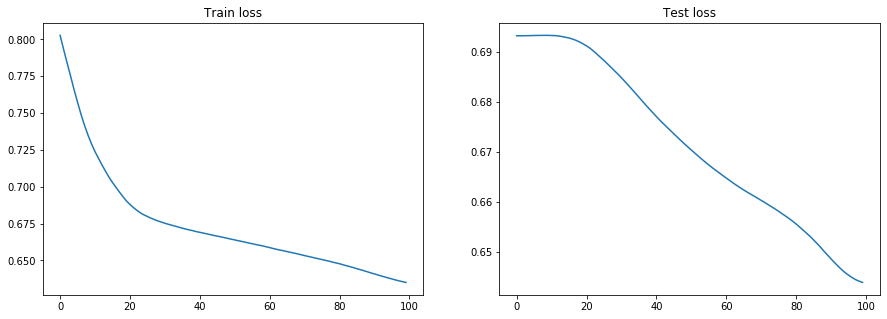

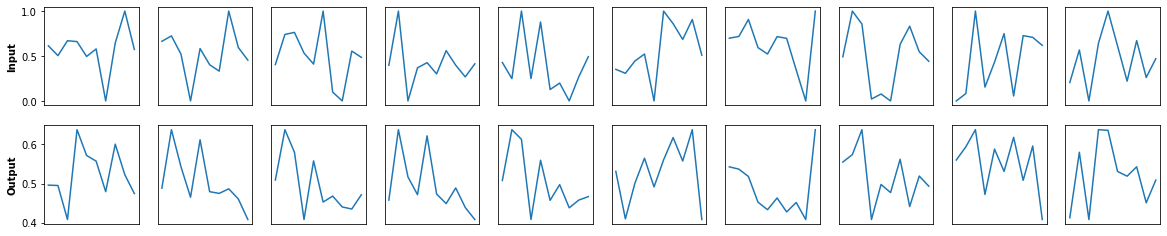

In [51]:
plot_history(history)
plot_examples(X_test_sample,decoded_stocks)

# Encoder로 Feature생성

In [110]:
X_train_simple = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_simple = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)

autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(X_train_simple, X_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(X_test_simple, X_test_simple))

decoded_stocks = autoencoder.predict(X_test_simple)
#############
compress_X_train = encoder.predict(X_train_simple)
compress_X_test = encoder.predict(X_test_simple)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_32 (Dense)             (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 30ms/step - loss: 0.6951 - val_loss: 0.6969
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6935 - val_loss: 0.6951
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6921 - val_loss: 0.6935
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6908 - val_loss: 0.6922


In [111]:
print(X_train_simple.shape)
print(X_test_simple.shape)

(4823, 10)
(200, 10)


In [112]:
print(compress_X_train.shape)
print(compress_X_test.shape)

(4823, 3)
(200, 3)


In [113]:
new_feature = np.concatenate([compress_X_train,compress_X_test])
tmp_df = pd.DataFrame(new_feature,columns=['comp_fe1','comp_fe2','comp_fe3'])

In [118]:
tmp_df

,comp_fe1,comp_fe2,comp_fe3
0,0.777989,0.292651,0.788388
1,0.737351,0.434818,0.114055
2,0.326330,0.000000,0.029802
3,0.000000,0.948595,0.316138
4,0.450393,1.128876,0.998128
...,...,...,...
5018,0.673723,0.245797,0.466013
5019,0.507891,0.000000,1.162836
5020,1.141447,0.500879,0.416258
5021,1.094415,0.360988,1.223480


In [115]:
snp500_df.head()

,Adj Close,pct_change,log_ret
0,1469.250000,NaN,NaN
1,1455.219971,-0.009549,-0.009595
2,1399.420044,-0.038345,-0.039099
3,1402.109985,0.001922,0.001920
4,1403.449951,0.000956,0.000955


In [116]:
snp500_df.loc[11:].reset_index(drop=True).join(tmp_df,how='left')

,Adj Close,pct_change,log_ret,comp_fe1,comp_fe2,comp_fe3
0,1455.140015,-0.006832,-0.006856,0.777989,0.292651,0.788388
1,1455.900024,0.000522,0.000522,0.737351,0.434818,0.114055
2,1445.569946,-0.007095,-0.007121,0.326330,0.000000,0.029802
3,1441.359985,-0.002912,-0.002917,0.000000,0.948595,0.316138
4,1401.530029,-0.027634,-0.028023,0.450393,1.128876,0.998128
...,...,...,...,...,...,...
5018,3240.020020,0.000034,0.000034,0.673723,0.245797,0.466013
5019,3221.290039,-0.005781,-0.005798,0.507891,0.000000,1.162836
5020,3230.780029,0.002946,0.002942,1.141447,0.500879,0.416258
5021,3257.850098,0.008379,0.008344,1.094415,0.360988,1.223480


# 1D Convolutional AutoEncoder

In [126]:
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D

Input_window = Input(shape=(window_length,1)) 
x = Conv1D(16,3,activation='relu',padding='same')(Input_window) #10차원
x = BatchNormalization()(x)
x = MaxPooling1D(2,padding='same')(x) #5차원
x=  Conv1D(1,3,activation='relu',padding='same')(x) #3차원
x = BatchNormalization()(x)

encoded = MaxPooling1D(2,padding='same')(x) #3차원
encoder = Model(Input_window, encoded)

x = Conv1D(1,3,activation='relu',padding='same')(encoded) #3차원
x = BatchNormalization()(x)
x = UpSampling1D(2)(x) #6차원
x = Conv1D(16,2,activation='relu')(x) #5차원
x = BatchNormalization()(x)
x = UpSampling1D(2)(x) #10차원
decoded = Conv1D(1,3,activation='sigmoid',padding='same')(x) #10차원

autoencoder = Model(Input_window, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

history = autoencoder.fit(X_train,X_train,
                          epochs = epochs,
                          batch_size = 1024,
                          shuffle = True,
                          validation_data = (X_test,X_test))
decoded_stocks = autoencoder.predict(X_test)

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 10, 16)            64        
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 1)              49        
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 1)              4         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 1)              0  

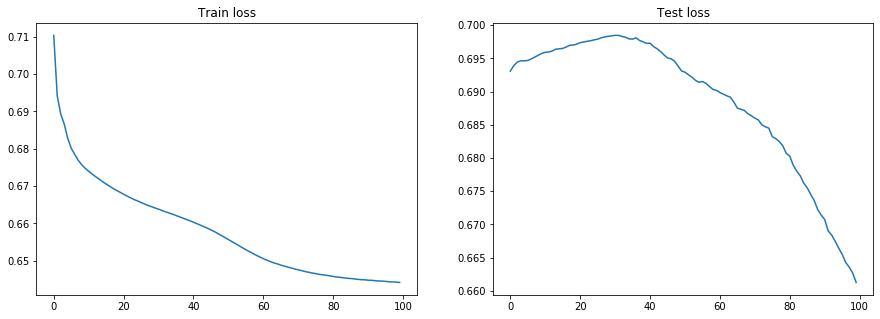

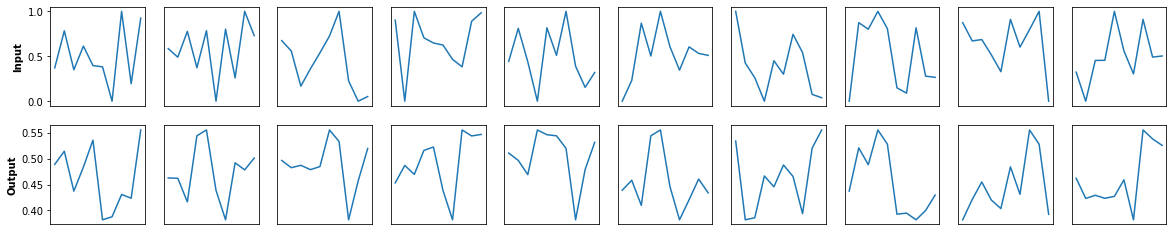

In [128]:
plot_history(history)
plot_examples(X_test,decoded_stocks)

# LSTM AutoEncoder

In [137]:
from keras.layers import LSTM,RepeatVector
from keras.models import Model

inputs = Input(shape=(window_length,1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1,return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs,decoded)
encoder = Model(inputs,encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
history = sequence_autoencoder.fit(X_train,X_train,
                                   epochs = epochs,
                                   batch_size = 1024,
                                   shuffle = True,
                                   validation_data =(X_test,X_test))

decoded_stocks = sequence_autoencoder.predict(X_test)

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 271ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 2/100
5/5 [==============================] - 2s 402ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 3/100
5/5 [==============================] - 0s 22ms/ste

5/5 [==============================] - 0s 24ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 76/100
5/5 [==============================] - 0s 23ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 77/100
5/5 [==============================] - 0s 27ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 78/100
5/5 [==============================] - 0s 23ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 79/100
5/5 [==============================] - 0s 25ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 80/100
5/5 [==============================] - 0s 24ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 81/100
5/5 [==============================] - 0s 25ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 82/100
5/5 [==============================] - 0s 23ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 83/100
5/5 [==============================] - 0s 23ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 84/100
5/5 [==============================] - 0s 22ms/step - loss: 7.6933 - val_loss: 7.9213
Epoch 85/100
5/5 [=====

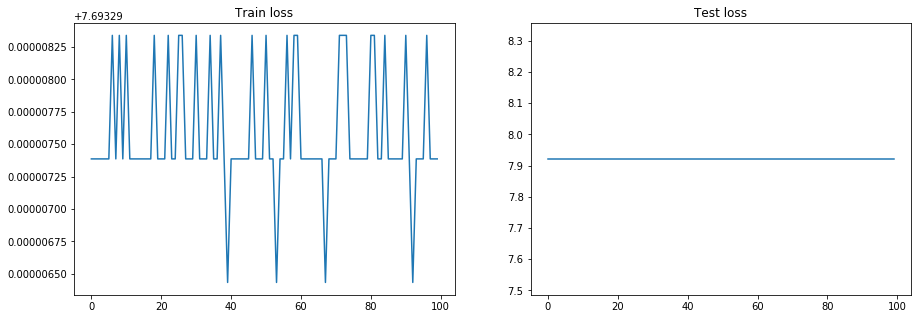

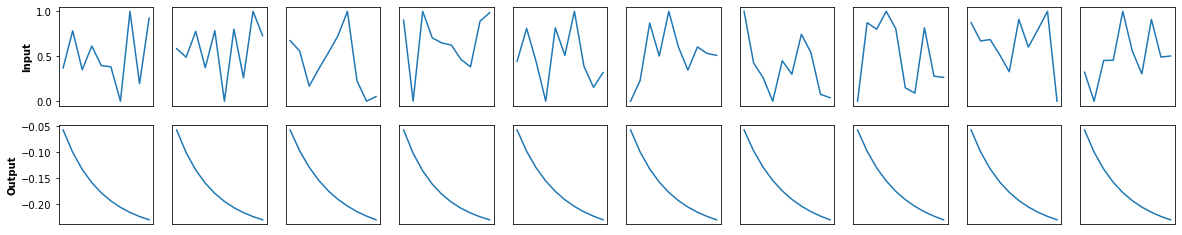

In [138]:
plot_history(history)
plot_examples(X_test,decoded_stocks)